In [14]:
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from scipy.stats import mannwhitneyu

# all the correction approaches
all_methods = [
    'note_1_text',
    'note_2_text',
    'correction_response (ours, time reference: high-qual note)',
    'correction_response (ours, time reference: avg-qual note)',
    'correction_response (ours removing {retrieval+image}, i.e., vanilla gpt-4)',
    'correction_response (ours removing retrieval)',
    'correction_response (ours removing image)',
    'correction_response (ours, time reference: tweet)'
]

# all the annotations who completed the tasks
all_users = [  
    'group1_user1',
    'group1_user2',
    'group2_user1',
    'group2_user2',  
    'group3_user1',
    'group3_user2',
    'group4_user1',
    'group4_user2',
    'group5_user1',
    'group5_user2'
]

# plot setup 
plt.style.use('default')
plt.rcParams['font.family'] = 'Helvetica'

matplotlib.rcParams['font.size'] = 12

target_methods_mapping = {
    'correction_response (ours, time reference: tweet)': 'MUSE',
    'correction_response (ours removing {retrieval+image}, i.e., vanilla gpt-4)': 'GPT-4',
    'note_1_text': 'Laypeople (high)',
    'note_2_text': 'Laypeople (avg)'
}

method_color = {
    'MUSE': '#8798C4',
    'GPT-4': '#BABFD4',
    'Laypeople (high)': '#F8D3A6',
    'Laypeople (avg)': '#F7E6CC'
}

method_marker = {
    'MUSE': 's',
    'GPT-4': 'o',
    'Laypeople (high)': '>',
    'Laypeople (avg)': '<'
}


In [15]:
path = '../data/'

# process annotations
df_eval = pd.read_csv(path + 'Q9-overall_quality.csv', dtype=str)
phase_1_post_ids = ['100', '107', '110', '114', '118', '119', '124', '128', '142', '144', '149', '152', '163', '173', '184']
df_eval = df_eval[~df_eval['post_id'].isin(phase_1_post_ids)]

# process responses
postId_tweetId = pd.read_csv(path + 'tweetid_postid.csv', dtype=str)
df_resp_mm = pd.read_csv(path + 'responses_multimodal.csv', dtype=str)
df_resp_mm = df_resp_mm.merge(postId_tweetId, on='tweet_id', how='left')
df_resp_mm['tweet_modality'] = ['multimodal'] * df_resp_mm.shape[0]
df_resp_um = pd.read_csv(path + 'responses_unimodal.csv', dtype=str)
df_resp_um = df_resp_um.merge(postId_tweetId, on='tweet_id', how='left')
df_resp_um['tweet_modality'] = ['unimodal'] * df_resp_um.shape[0]
df_resp = pd.concat((df_resp_mm, df_resp_um))
df_resp = df_resp.fillna('nan')

tweetId_tweetDomain = pd.read_csv(path + 'tweetid_domain.csv', dtype=str)
df_resp = df_resp.merge(tweetId_tweetDomain, on='tweet_id', how='left')
postId_tweetDomain = dict(zip(df_resp['post_id'], df_resp['tweet_domain']))

# get the post ids whose responses were evaluated by one participant only
userName_tweetIds = pd.read_csv(path + 'username_tweetids.csv', dtype=str)
userName_tweetIds = dict(zip(userName_tweetIds['username'], [tweet_ids.split(';') for tweet_ids in userName_tweetIds['tweet_ids']]))

tweetId_postId = pd.read_csv(path + 'tweetid_postid.csv', dtype=str)
tweetId_postId = dict(zip(tweetId_postId['tweet_id'], tweetId_postId['post_id']))

userName_postIds = {}
for username, tweet_ids in userName_tweetIds.items():
    if username in all_users:
        userName_postIds[username] = [tweetId_postId[tweet_id] for tweet_id in tweet_ids]

userName_postIds_2 = {}
for group_num in range(1, 6):
    u0, u1 = 'group'+str(group_num)+'_user1', 'group'+str(group_num)+'_user2'
    post_ids_u0 = set(userName_postIds[u0])
    post_ids_u1 = set(userName_postIds[u1])
    post_ids_u0_unique = post_ids_u0.difference(post_ids_u1)
    post_ids_u1_unique = post_ids_u1.difference(post_ids_u0)

    userName_postIds_2[u0] = list(post_ids_u0_unique)
    userName_postIds_2[u1] = list(post_ids_u1_unique)
    
# get the labels for each approach
methods, scores, domains = [], [], []
for user in all_users:
    post_ids = df_eval[df_eval['username'] == user]['post_id'].unique()
    for post_id in post_ids:
        method_label, method_domain = {}, {}

        df = df_eval[(df_eval['username'] == user) & (df_eval['post_id'] == post_id)]

        methods_included = df['response_type'].unique()
        for method in methods_included:
            labels = list(df[df['response_type'] == method]['label'])
            domain = postId_tweetDomain[post_id]

            if len(labels) != 1:
                assert ('ERROR')
            else:
                methods.append(method)
                scores.append(labels[0])
                domains.append(domain)
                if post_id in userName_postIds_2[user]:
                    methods.append(method)
                    scores.append(labels[0])
                    domains.append(domain)
                method_label[method] = labels[0]
                method_domain[method] = domain

        methods_excluded = set(all_methods).difference(set(methods_included))
        for method in methods_excluded:
            responses = list(df_resp[df_resp['post_id'] == post_id][method])

            if len(responses) != 1:
                print('ERROR')
            else:
                if responses[0] == 'nan':
                    continue
                elif responses[0] == '~':
                    methods.append(method)
                    scores.append(method_label['correction_response (ours, time reference: high-qual note)'])
                    domains.append(method_domain['correction_response (ours, time reference: high-qual note)'])
                    if post_id in userName_postIds_2[user]:
                        methods.append(method)
                        scores.append(method_label['correction_response (ours, time reference: high-qual note)'])
                        domains.append(method_domain['correction_response (ours, time reference: high-qual note)'])
                elif responses[0] == '|||':
                    methods.append(method)
                    scores.append(method_label['correction_response (ours, time reference: avg-qual note)'])
                    domains.append(method_domain['correction_response (ours, time reference: avg-qual note)'])
                    if post_id in userName_postIds_2[user]:
                        methods.append(method)
                        scores.append(method_label['correction_response (ours, time reference: avg-qual note)'])
                        domains.append(method_domain['correction_response (ours, time reference: avg-qual note)'])
                elif responses[0] == '///':
                    methods.append(method)
                    scores.append(method_label['correction_response (ours removing {retrieval+image}, i.e., vanilla gpt-4)'])
                    domains.append(method_domain['correction_response (ours removing {retrieval+image}, i.e., vanilla gpt-4)'])
                    if post_id in userName_postIds_2[user]:
                        methods.append(method)
                        scores.append(method_label['correction_response (ours removing {retrieval+image}, i.e., vanilla gpt-4)'])
                        domains.append(method_domain['correction_response (ours removing {retrieval+image}, i.e., vanilla gpt-4)'])
                elif responses[0] == '*':
                    methods.append(method)
                    scores.append(method_label['correction_response (ours removing retrieval)'])
                    domains.append(method_domain['correction_response (ours removing retrieval)'])
                    if post_id in userName_postIds_2[user]:
                        methods.append(method)
                        scores.append(method_label['correction_response (ours removing retrieval)'])
                        domains.append(method_domain['correction_response (ours removing retrieval)'])
                elif responses[0] == '$':
                    methods.append(method)
                    scores.append(method_label['correction_response (ours removing image)'])
                    domains.append(method_domain['correction_response (ours removing image)'])
                    if post_id in userName_postIds_2[user]:
                        methods.append(method)
                        scores.append(method_label['correction_response (ours removing image)'])
                        domains.append(method_domain['correction_response (ours removing image)'])

df = pd.DataFrame({
    'Method': methods,
    'Quality': scores,
    'Domain': domains
})

df = {
    "Other": df[df['Domain'] == 'Other'][['Method', 'Quality']],
    "Health & medicine": df[df['Domain'] == 'Health & medicine'][['Method', 'Quality']],
    "Social issues & human rights": df[df['Domain'] == 'Social issues & human rights'][['Method', 'Quality']],
    "Crime & law": df[df['Domain'] == 'Crime & law'][['Method', 'Quality']],
    "Economy & business": df[df['Domain'] == 'Economy & business'][['Method', 'Quality']],
    "Politics & international affairs": df[df['Domain'] == 'Politics & international affairs'][['Method', 'Quality']]
}

dict_plot = {key: {} for key in df.keys()}
for key, value in df.items():
    for method in target_methods_mapping.keys():
        scores = list(value[value['Method'] == method]['Quality'])
        scores = np.array([int(s) for s in scores])
        dict_plot[key][target_methods_mapping[method]] = scores
    dict_plot[key] = {method: scores for method, scores in dict_plot[key].items()}
    
method_mean = {key: {} for key in dict_plot.keys()}
method_std = {key: {} for key in dict_plot.keys()}
for key, value in dict_plot.items():
    method_mean[key] = {method: np.mean(scores) for method, scores in dict_plot[key].items()}
    method_std[key] = {method: np.std(scores) for method, scores in dict_plot[key].items()}

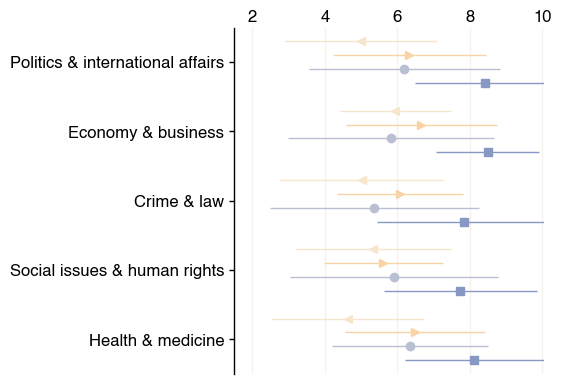

In [16]:
fig, ax = plt.subplots(figsize=(4, 4.5))

delta = [-0.3, -0.1, 0.1, 0.3]
y = 0
for domain in method_mean.keys():
    if domain != 'Other':
        y += 1
        for j, method in enumerate(method_color.keys()):
            ax.errorbar(method_mean[domain][method], y + delta[j],
                        xerr=method_std[domain][method], 
                        elinewidth=1, 
                        marker=method_marker[method], 
                        color=method_color[method])

ax.set_xlim([1.5, 10.05])
ax.set_ylim([1,5])
ax.set_xticks(ticks=[2,4,6,8,10])
ax.set_yticks(ticks=[1,2,3,4,5], labels=[d for d in method_mean.keys() if d != 'Other'])
ax.xaxis.set_label_position('top')
plt.setp(ax.spines.values(), color='k', linewidth=1)
ax.tick_params(top=False, labeltop=True, bottom=False, labelbottom=False, axis='x', pad=-1.5)
ax.set_ylim([0.5, 5.5])
ax.yaxis.set_tick_params(width=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_axisbelow(True)
ax.grid(axis='x', color='#F6F2EC', linewidth=1)